# Initial loading & analysis

In [7]:
require(pscl)
require(tibble)
library(tidyverse)

In [8]:
fake_cres<-read_csv("fake_cres.csv")

New names:
• `` -> `...1`


Rows: 14312 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): CRE, Cell_type
dbl (3): ...1, replicate_ID, umi_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
#definitely matters for this one
fake_cres$replicate_ID <- factor(fake_cres$replicate_ID)

#probably doesn't matter for these, but to be safe...
fake_cres$CRE <- factor(fake_cres$CRE)
fake_cres$Cell_type <- factor(fake_cres$Cell_type)

In [10]:
head(fake_cres)

...1,CRE,Cell_type,replicate_ID,umi_count
<dbl>,<fct>,<fct>,<fct>,<dbl>
0,nobody,brain,1,0
1,nobody,brain,1,0
2,nobody,brain,1,0
3,nobody,brain,1,0
4,nobody,brain,1,0
5,nobody,brain,1,0


```
zinb_logit <- zeroinfl(UMIs_mBC ~ rep_id + CRE_id | rep_id,
               dist = 'negbin',
               data = data_cardio, link='logit')
```

In [11]:
zinb <- zeroinfl(umi_count ~ CRE*Cell_type +0|replicate_ID,
    dist='negbin',
    data=fake_cres)

# in NB estimation no intercept makes the coef. more interpretable
# It also makes logical sense : No CREs means no expression !
# CRE alone : inherent CRE strength (like TFs which are in ALL cell types). 
# Cell-type alone : probably how much RNA is in that cell-type
# CRE x cell-type: how cell-type modifies CRE activity (what TFs are ONLY in that cell type)
# note that umi_count ~ CRE:`Cell-type` alone fails to converge

In [12]:
zinb


Call:
zeroinfl(formula = umi_count ~ CRE * Cell_type + 0 | replicate_ID, data = fake_cres, 
    dist = "negbin")

Count model coefficients (negbin with log link):
               CREeverybody                 CREneurogene  
                    4.63990                      2.74070  
                  CREnobody                   CREredgene  
                    0.66602                      4.65945  
                CREsomebody               Cell_typebrain  
                    2.52532                      0.03975  
CREneurogene:Cell_typebrain     CREnobody:Cell_typebrain  
                    1.78701                     -0.67922  
  CREredgene:Cell_typebrain   CREsomebody:Cell_typebrain  
                   -1.27374                     -0.26347  
Theta = 3.487 

Zero-inflation model coefficients (binomial with logit link):
  (Intercept)  replicate_ID2  replicate_ID3  
       1.3552        -1.3270         0.8892  


First, let's examine theta. One assumes this is the value in $\sigma^2=\mu+\mu^2/\theta$. 

A decent estimate : 3.48 is reasonably close to 3.333.

Ok, let's start with the zero-inflation parameter, since that's simpler. 

logit(binomial parameter)=intercept + bool_id2 * (-1.3278) + bool_id3 * (0.8831)

Parameter is parameter of binomial distribution. Assuming "success" means "not a zero", then zero inflation as picked in data-creation will be 1-binomial.

(If "success" is "is a zero" then we can skip the 1- part. )

# Recapitulation of zero-inflation parameter

In [13]:
typeof(zinb)

[1] "list"

In [14]:
ls(zinb)

[1] "call"          "coefficients"  "contrasts"     "control"      
 [5] "converged"     "df.null"       "df.residual"   "dist"         
 [9] "fitted.values" "formula"       "levels"        "link"         
[13] "linkinv"       "loglik"        "method"        "model"        
[17] "n"             "offset"        "optim"         "residuals"    
[21] "SE.logtheta"   "start"         "terms"         "theta"        
[25] "vcov"          "weights"       "y"

In [15]:
zinb[["coefficients"]]

$count
               CREeverybody                CREneurogene 
                 4.63990137                  2.74070479 
                  CREnobody                  CREredgene 
                 0.66602398                  4.65945006 
                CREsomebody              Cell_typebrain 
                 2.52532093                  0.03974839 
CREneurogene:Cell_typebrain    CREnobody:Cell_typebrain 
                 1.78701484                 -0.67921565 
  CREredgene:Cell_typebrain  CREsomebody:Cell_typebrain 
                -1.27374496                 -0.26346564 

$zero
  (Intercept) replicate_ID2 replicate_ID3 
    1.3551995    -1.3270396     0.8892169

In [16]:
zinb[["coefficients"]][["zero"]]

(Intercept) replicate_ID2 replicate_ID3 
    1.3551995    -1.3270396     0.8892169

In [17]:
#OK, let's make a little matrix of all possibilities...
zeroinfl<-matrix(c(1,1,1,0,1,0,0,0,1),nrow=3,ncol=3)

rownames(zeroinfl)=levels(fake_cres$replicate_ID)
colnames(zeroinfl)<-names(zinb[["coefficients"]][["zero"]])

t(zeroinfl)

,1,2,3
(Intercept),1,1,1
replicate_ID2,0,1,0
replicate_ID3,0,0,1


In [18]:
weighted=zinb[["coefficients"]][["zero"]]*t(zeroinfl)#*matrix(zeroinfl,nrow=3,ncol=1)
weighted

,1,2,3
(Intercept),1.355199,1.355199,1.3551995
replicate_ID2,0.000000,-1.327040,0.0000000
replicate_ID3,0.000000,0.000000,0.8892169


In [19]:
logited_binom=colSums(weighted)
logited_binom

1          2          3 
1.35519950 0.02815991 2.24441639

In [20]:
invlogit <- function(x) {
  return(1 / (1 + exp(-x)))
}
invlogit(logited_binom)

1         2         3 
0.7949784 0.5070395 0.9041678

Comparing to the original valies of 0.8, 0.5, 0.9, we see this is quite accurate!

# Recapitulating $\mu$ values

In [52]:
mean_design=matrix(c(1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0),nrow=10,ncol=10)
colnames(mean_design)<-c("everybody_brain","neurogene_brain","nobody_brain","redgene_brain","somebody_brain","everybody_blood","neurogene_blood","nobody_blood","redgene_blood","somebody_blood")
rownames(mean_design)<-names(zinb[["coefficients"]][["count"]])
mean_design

,everybody_brain,neurogene_brain,nobody_brain,redgene_brain,somebody_brain,everybody_blood,neurogene_blood,nobody_blood,redgene_blood,somebody_blood
CREeverybody,1,0,0,0,0,1,0,0,0,0
CREneurogene,0,1,0,0,0,0,1,0,0,0
CREnobody,0,0,1,0,0,0,0,1,0,0
CREredgene,0,0,0,1,0,0,0,0,1,0
CREsomebody,0,0,0,0,1,0,0,0,0,1
Cell_typebrain,1,1,1,1,1,0,0,0,0,0
CREneurogene:Cell_typebrain,0,1,0,0,0,0,0,0,0,0
CREnobody:Cell_typebrain,0,0,1,0,0,0,0,0,0,0
CREredgene:Cell_typebrain,0,0,0,1,0,0,0,0,0,0
CREsomebody:Cell_typebrain,0,0,0,0,1,0,0,0,0,0


In [53]:
mean_weights=mean_design*zinb[["coefficients"]][["count"]]
mean_weights

,everybody_brain,neurogene_brain,nobody_brain,redgene_brain,somebody_brain,everybody_blood,neurogene_blood,nobody_blood,redgene_blood,somebody_blood
CREeverybody,4.63990137,0.00000000,0.00000000,0.00000000,0.00000000,4.639901,0.000000,0.000000,0.00000,0.000000
CREneurogene,0.00000000,2.74070479,0.00000000,0.00000000,0.00000000,0.000000,2.740705,0.000000,0.00000,0.000000
CREnobody,0.00000000,0.00000000,0.66602398,0.00000000,0.00000000,0.000000,0.000000,0.666024,0.00000,0.000000
CREredgene,0.00000000,0.00000000,0.00000000,4.65945006,0.00000000,0.000000,0.000000,0.000000,4.65945,0.000000
CREsomebody,0.00000000,0.00000000,0.00000000,0.00000000,2.52532093,0.000000,0.000000,0.000000,0.00000,2.525321
Cell_typebrain,0.03974839,0.03974839,0.03974839,0.03974839,0.03974839,0.000000,0.000000,0.000000,0.00000,0.000000
CREneurogene:Cell_typebrain,0.00000000,1.78701484,0.00000000,0.00000000,0.00000000,0.000000,0.000000,0.000000,0.00000,0.000000
CREnobody:Cell_typebrain,0.00000000,0.00000000,-0.67921565,0.00000000,0.00000000,0.000000,0.000000,0.000000,0.00000,0.000000
CREredgene:Cell_typebrain,0.00000000,0.00000000,0.00000000,-1.27374496,0.00000000,0.000000,0.000000,0.000000,0.00000,0.000000
CREsomebody:Cell_typebrain,0.00000000,0.00000000,0.00000000,0.00000000,-0.26346564,0.000000,0.000000,0.000000,0.00000,0.000000


In [54]:
log_mu=colSums(mean_weights)
mu=exp(log_mu)
mu

everybody_brain neurogene_brain    nobody_brain   redgene_brain  somebody_brain 
     107.732334       96.299971        1.026912       30.736580        9.990191 
everybody_blood neurogene_blood    nobody_blood   redgene_blood  somebody_blood 
     103.534136       15.497904        1.946483      105.578005       12.494905

Pretty good!

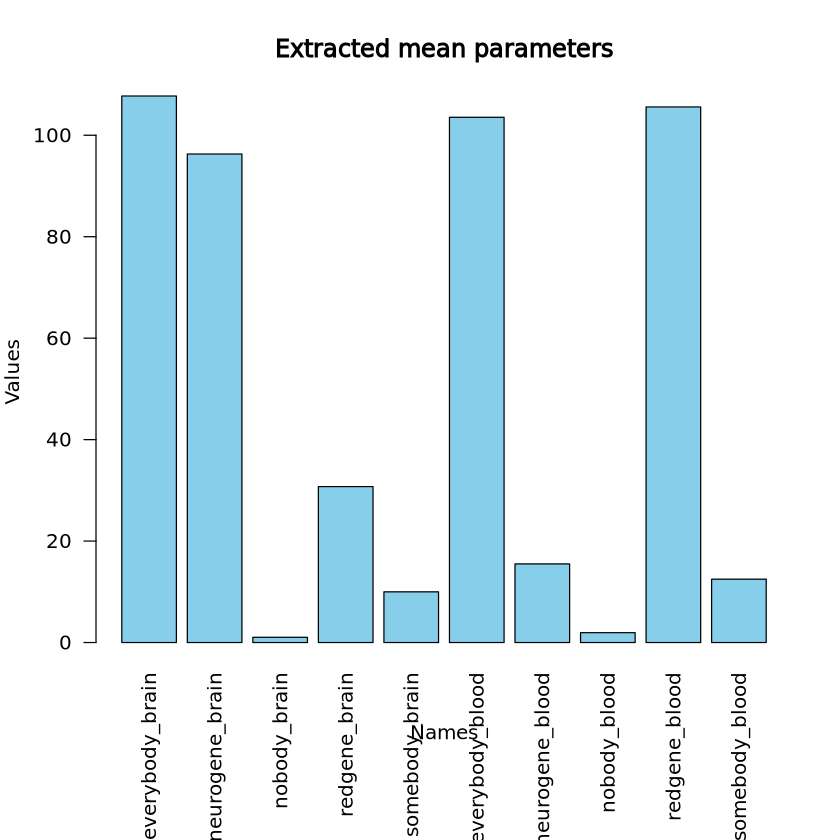

In [56]:
par(mar = c(8, 4, 4, 2))
barplot(mu, main = "Extracted mean parameters", col = "skyblue", ylab = "Values", xlab = "Names",las=2)


# Reconstructing $\sigma^2$ values

In [59]:
mu+mu**2/zinb[["theta"]]

everybody_brain neurogene_brain    nobody_brain   redgene_brain  somebody_brain 
    3436.174591     2755.807379        1.329336      301.668379       38.611958 
everybody_blood neurogene_blood    nobody_blood   redgene_blood  somebody_blood 
    3177.620174       84.378172        3.033033     3302.233179       57.267759

Also pretty good!

# Examining alternate total models

Let's take a look at what happens if we perform the same regression, but augment it by regressing mean parameter on replicate ID...

In [21]:
zinb_aug <- zeroinfl(umi_count ~ CRE*Cell_type + replicate_ID +0|replicate_ID,
    dist='negbin',
    data=fake_cres)

In [22]:
zinb_aug


Call:
zeroinfl(formula = umi_count ~ CRE * Cell_type + replicate_ID + 0 | replicate_ID, 
    data = fake_cres, dist = "negbin")

Count model coefficients (negbin with log link):
               CREeverybody                 CREneurogene  
                   4.629857                     2.730615  
                  CREnobody                   CREredgene  
                   0.656210                     4.648954  
                CREsomebody               Cell_typebrain  
                   2.514607                     0.039979  
              replicate_ID2                replicate_ID3  
                   0.007276                     0.047780  
CREneurogene:Cell_typebrain     CREnobody:Cell_typebrain  
                   1.786477                    -0.681405  
  CREredgene:Cell_typebrain   CREsomebody:Cell_typebrain  
                  -1.273701                    -0.263477  
Theta = 3.4891 

Zero-inflation model coefficients (binomial with logit link):
  (Intercept)  replicate_ID2  repl

Unsurprisingly, we find that the coefficients on replicate IDs are very small, indicating they have a small effect on the mean parameter of the distro... If we were to find large parameters here we'd want to regress them out! As it stands, I think we can neglect them and proceed with the original model.